# SkimLit: Sequential Sentence Classification in Medical Abstracts

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The source: 
* https://arxiv.org/abs/1710.06071
* https://arxiv.org/abs/1612.05251



In [ ]:
## Confirm access GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-ab53d16b-cb8f-3f3b-8437-c4caaa0e7c6e)


## Get data

Data stored on GitHub : https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Numbers has been replaced by _at_sign(@)

In [ ]:
# Check what files are in  the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start experiiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Become one with data

Write a function to read in all of the lines of a target text file.

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the targeet filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the lines with the training lines
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Data have to be like this:

```
[{'line_number':0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity',
  'total_lines': 11},
 ... (next_sentence)]
```

## Create a function which turns each into the above format to prepare data


In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentence are in the current abstract and what sentence 
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"):  # check to see if the is an ID line
      abstract_id = line    
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if line is anew line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines 
      
      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract 
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract (start from 0)
        abstract_samples.append(line_data)  # add line data to abstract samples list

    else: # if the above condotions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line  

  return abstract_samples
    

In [ ]:
# Get data from file and preprocess it
%%time 
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name of val
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 616 ms, sys: 127 ms, total: 742 ms
Wall time: 746 ms


In [ ]:
# Check samples
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Turn list of data into DataFrame

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

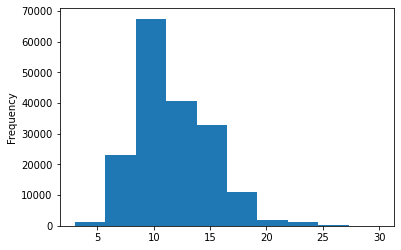

In [ ]:
# Check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences


In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels

In [ ]:
# One hot encoder labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
# Check labels
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extact labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check labels
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline  

# Create a pipeline 
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/Azamat0315277/Helper_functions/main/helper_functions.py

--2021-12-14 12:42:43--  https://raw.githubusercontent.com/Azamat0315277/Helper_functions/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-14 12:42:43 (68.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing data for deep sequence models

Create vectorization and embedding layers

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Find average length of sentences
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

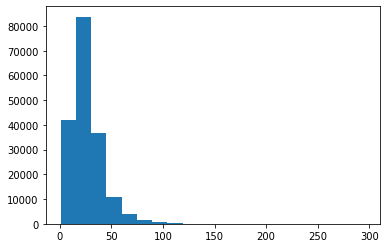

In [ ]:
# Check dictribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# how long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

In [ ]:
# Set max vocab size (taken from table 2 :  https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorizer text: {text_vectorizer([target_sentence])}")

Text:
compared with the main finding of the pilot study , there was no greater advantage of ips for those with adequate transportation ( nnt = @ ) or adequate housing ( nnt = @ ) .

Length of text: 174

Vectorizer text: [[  34    7    2  524 2036    4    2  689   17   61   10   33  182 2003
     4 4885   11  125    7 1389 9031 5819   16 1389 5503 5819    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Create custom text embedding

In [ ]:
# Create token embedding layer 
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")


In [ ]:
# Show example embedding
print(f"Sentence before vectorizer: \n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorizer: 
 compared with the main finding of the pilot study , there was no greater advantage of ips for those with adequate transportation ( nnt = @ ) or adequate housing ( nnt = @ ) .

Sentence after vectorization (before embedding):
 [[  34    7    2  524 2036    4    2  689   17   61   10   33  182 2003
     4 4885   11  125    7 1389 9031 5819   16 1389 5503 5819    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.04109339  0.0176312  -0.04228276 ... -0.00360967 -0.03453453
    0.02679862]
  [ 0.03196872  0.03918635  0.02243996 ...  0.02342857  0.03689763
   -0.01844921]
  [ 0.04395337 -0.01944519  0.04948676 ...  0.01181229  0.00638418
   -0.00096655]
  ...
  [-0.00786876  0.03046924 -0.04751024 ... -0.04699498 -0.00939912
   -0.0337575 ]
  [-0.00786876  0.03046924 -0.04751024 ... -0.04699498 -0.00939912
   -0.0337575 ]
  [-0.0078

## Creating datasets (making sure data loads as fast as possible)

Link: 
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
# Take the TensorSlicesDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)  # vectorize text inputs
token_embedings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embedings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_11 (Dense)            (None, 5)                 325 

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 10s 16ms/step - loss: 0.9172 - accuracy: 0.6357 - val_loss: 0.6840 - val_accuracy: 0.7400
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6594 - accuracy: 0.7543 - val_loss: 0.6300 - val_accuracy: 0.7653
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6214 - accuracy: 0.7738 - val_loss: 0.5978 - val_accuracy: 0.7832


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.6018 - accuracy: 0.7840


[0.6018309593200684, 0.7840262055397034]

In [ ]:
# Make predictions 
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.1037896e-01, 1.5060426e-01, 1.2105780e-01, 2.8984708e-01,
         2.8111879e-02],
        [4.6186590e-01, 2.3830841e-01, 1.1180427e-02, 2.8321299e-01,
         5.4323096e-03],
        [1.2931554e-01, 1.0351518e-02, 1.0297997e-03, 8.5928154e-01,
         2.1568254e-05],
        ...,
        [2.1715348e-06, 6.8771635e-04, 4.8944581e-04, 1.5880837e-06,
         9.9881905e-01],
        [6.3811041e-02, 4.2778078e-01, 1.2379185e-01, 7.0718899e-02,
         3.1389743e-01],
        [1.6752610e-01, 6.2320489e-01, 3.1449076e-02, 3.6937311e-02,
         1.4088266e-01]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1) # get maximum value to convert them to label
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.40262147491063,
 'f1': 0.7817028992313194,
 'precision': 0.7804637227491238,
 'recall': 0.7840262147491063}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model_2: Feature extraction with pretrained token embeddings

Pretrained word embeddings from TensorFlow Hub
Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test the pretained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 at one year , the majority of patients ( @ % ) responded positively to using the system again .
Sentence after embedding:
[-0.06173588 -0.04680525 -0.04148723 -0.02052485 -0.09860283  0.01405569
  0.02163829 -0.04276956  0.02970904 -0.00179998  0.05685139  0.04858549
  0.00865657  0.08403905  0.01176086  0.01495825 -0.09248422  0.00677761
 -0.06922287  0.04038841  0.01263095 -0.00967518  0.04847031  0.02600154
 -0.00843759  0.01313583 -0.04264675  0.02685677  0.01016881  0.01467464]

Length of sentence embedding: 512


## Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [ ]:
# Define feature extraction modelusing TF Hub Layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x) # create teh output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dense_13 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model_2 the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 25ms/step - loss: 0.9185 - accuracy: 0.6498 - val_loss: 0.7967 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 13s 24ms/step - loss: 0.7681 - accuracy: 0.7021 - val_loss: 0.7548 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 13s 24ms/step - loss: 0.7512 - accuracy: 0.7135 - val_loss: 0.7376 - val_accuracy: 0.7154


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.7393 - accuracy: 0.7147


[0.7392644286155701, 0.7147160172462463]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.42739642, 0.36628884, 0.00167443, 0.19727   , 0.00737023],
       [0.34635484, 0.49916407, 0.00381432, 0.14758468, 0.00308213],
       [0.24415335, 0.16676277, 0.01853716, 0.53349835, 0.03704844],
       ...,
       [0.00168239, 0.00928097, 0.06008158, 0.0009743 , 0.9279807 ],
       [0.00421611, 0.04543097, 0.22396289, 0.00157126, 0.7248188 ],
       [0.18456163, 0.30124405, 0.4380696 , 0.00739365, 0.06873112]],
      dtype=float32)

In [ ]:
# Convert predictions
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.47160068846816,
 'f1': 0.7114402065449466,
 'precision': 0.7146751951677972,
 'recall': 0.7147160068846816}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model_3: Conv!D with character embeddings

Using char-level embeddings


### Creating a character-level tokenizer

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
# Text splitting non_character-level sequence into characters
split_chars(random_train_sentence)

'a t   o n e   y e a r   ,   t h e   m a j o r i t y   o f   p a t i e n t s   (   @   %   )   r e s p o n d e d   p o s i t i v e l y   t o   u s i n g   t h e   s y s t e m   a g a i n   .'

In [ ]:
# Split sequence-level dara splits into char-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# what's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

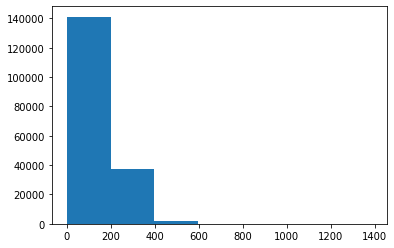

In [ ]:
# Check the distribution char_level data
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters to find max tokens(vocab size)
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
len(alphabet)

68

In [ ]:
# Create char_level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV= out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                   output_sequence_length=output_seq_char_len,
                                   standardize="lower_and_strip_punctuation",
                                   name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)


In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorizer chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 m e d i c a t i o n   w a s   t i t r a t e d   i n   @ - @ - w e e k   b l o c k s   s e p a r a t e d   b y   a   @ - w e e k   p l a c e b o   w a s h o u t   .
Length of random_train_chars: 70
\Vectorizer chars:
 [[15  2 10  4 11  5  3  4  7  6 20  5  9  3  4  3  8  5  3  2 10  4  6 20
   2  2 23 22 12  7 11 23  9  9  2 14  5  8  5  3  2 10 22 19  5 20  2  2
  23 14 12  5 11  2 22  7 20  5  9 13  7 16  3  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0 

## Creating a char-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper (figure 1) link: https://arxiv.org/pdf/1612.05251.pdf
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Test char embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Char embedding shape: {char_embed_example.shape}")

Charified text:
 m e d i c a t i o n   w a s   t i t r a t e d   i n   @ - @ - w e e k   b l o c k s   s e p a r a t e d   b y   a   @ - w e e k   p l a c e b o   w a s h o u t   .

Embedded chars. (after vectorization and embedding):
 [[[-0.03646528 -0.01265442  0.01572921 ...  0.02752111 -0.00031604
    0.02775482]
  [-0.03452856  0.0422243   0.0112818  ...  0.00143335 -0.01341695
   -0.02422563]
  [-0.03180242 -0.00364355 -0.01029275 ...  0.03707093  0.03760094
    0.03654205]
  ...
  [-0.03663013 -0.04857912 -0.04734394 ... -0.0414724  -0.04671049
   -0.0133597 ]
  [-0.03663013 -0.04857912 -0.04734394 ... -0.0414724  -0.04671049
   -0.0133597 ]
  [-0.03663013 -0.04857912 -0.04734394 ... -0.0414724  -0.04671049
   -0.0133597 ]]]

Char embedding shape: (1, 290, 25)


## Building a Conv1D model to fit char embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs,
                         name="model_3_conv1d_char_embeddings")


In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 

In [ ]:
# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create char level datsets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 7s 11ms/step - loss: 1.2496 - accuracy: 0.4889 - val_loss: 1.0457 - val_accuracy: 0.5725
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 1.0131 - accuracy: 0.5874 - val_loss: 0.9549 - val_accuracy: 0.6200
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9381 - accuracy: 0.6294 - val_loss: 0.8896 - val_accuracy: 0.6506


In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.20673959, 0.39377436, 0.04300887, 0.32657504, 0.02990217],
       [0.06053988, 0.64024633, 0.00327472, 0.27040318, 0.02553587],
       [0.0597054 , 0.2377024 , 0.25945827, 0.4053844 , 0.03774949],
       ...,
       [0.02994311, 0.0352534 , 0.11067765, 0.01784078, 0.806285  ],
       [0.01442905, 0.14823593, 0.2630422 , 0.02470427, 0.54958856],
       [0.36903757, 0.37400663, 0.18414839, 0.0573075 , 0.01549991]],
      dtype=float32)

In [ ]:
# Convert predictions probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.25552760492519,
 'f1': 0.6432839424538618,
 'precision': 0.6478594693120134,
 'recall': 0.6525552760492519}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 4:  Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)
1. Create a token-level embedding model(similar `model-1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) 
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])
# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

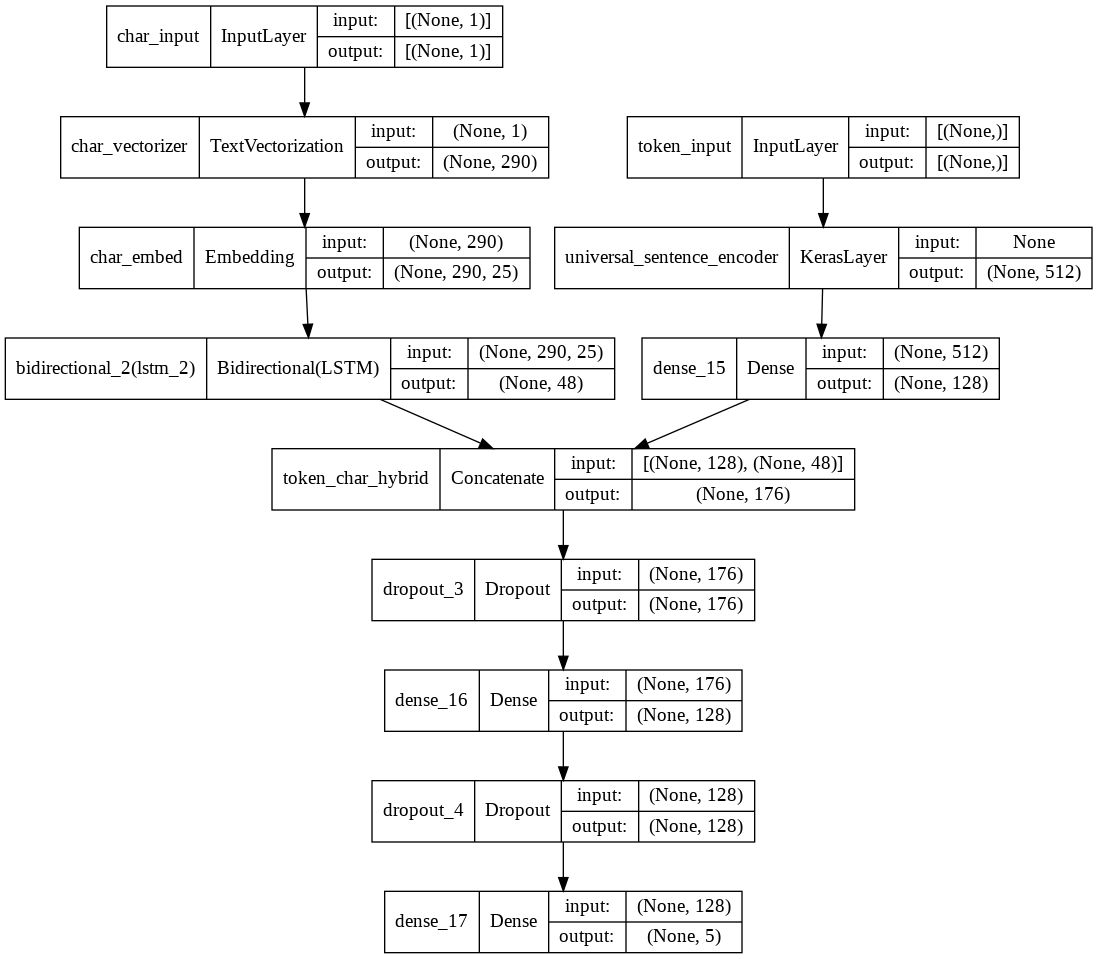

In [ ]:
# Plot hybrid token and character model
tf.keras.utils.plot_model(model_4,show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Combine chars nad tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat  the above steps for validation data

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
# Prefetch and batch val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check  training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [ ]:
# Fit the model
history_model_4 = model_4.fit(train_char_token_dataset,
                    steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                    epochs=3,
                    validation_data=val_char_token_dataset,
                    validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 91s 142ms/step - loss: 0.9742 - accuracy: 0.6133 - val_loss: 0.7849 - val_accuracy: 0.7051
Epoch 2/3
562/562 [==============================] - 75s 134ms/step - loss: 0.7990 - accuracy: 0.6926 - val_loss: 0.7183 - val_accuracy: 0.7241
Epoch 3/3
562/562 [==============================] - 71s 127ms/step - loss: 0.7739 - accuracy: 0.7027 - val_loss: 0.6983 - val_accuracy: 0.7377


In [ ]:
# Evaluate model
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 53s 56ms/step - loss: 0.7000 - accuracy: 0.7323


[0.6999529004096985, 0.7323248982429504]

In [ ]:
# Make predictions 
model_4_pred_probs = model_4.predict(val_char_token_dataset)

In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.2324904011651,
 'f1': 0.7296291360858495,
 'precision': 0.7340390955858289,
 'recall': 0.732324904011651}

## Model 5: Transfer leraning with pretained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


## Create posotional embeddings

In [ ]:
# Find different line numbers
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

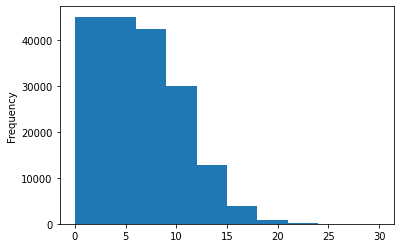

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist();

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [ ]:
# Look different numbers of total lines
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

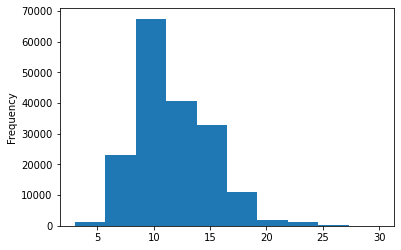

In [ ]:
train_df["total_lines"].plot.hist();

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df["total_lines"], 95)

18.0

In [ ]:
# Use Tenosrflow to create one-hot-encoded tensors of "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

## Building a tribrid (triple) embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)
# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)
# 3. Line numbers model
# inputs, shape 
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# Dense layer with 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# Combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embeding")([token_model.output,
                                                                             char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)
# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="tribrid_embedding_model")



In [ ]:
# Get summary 
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

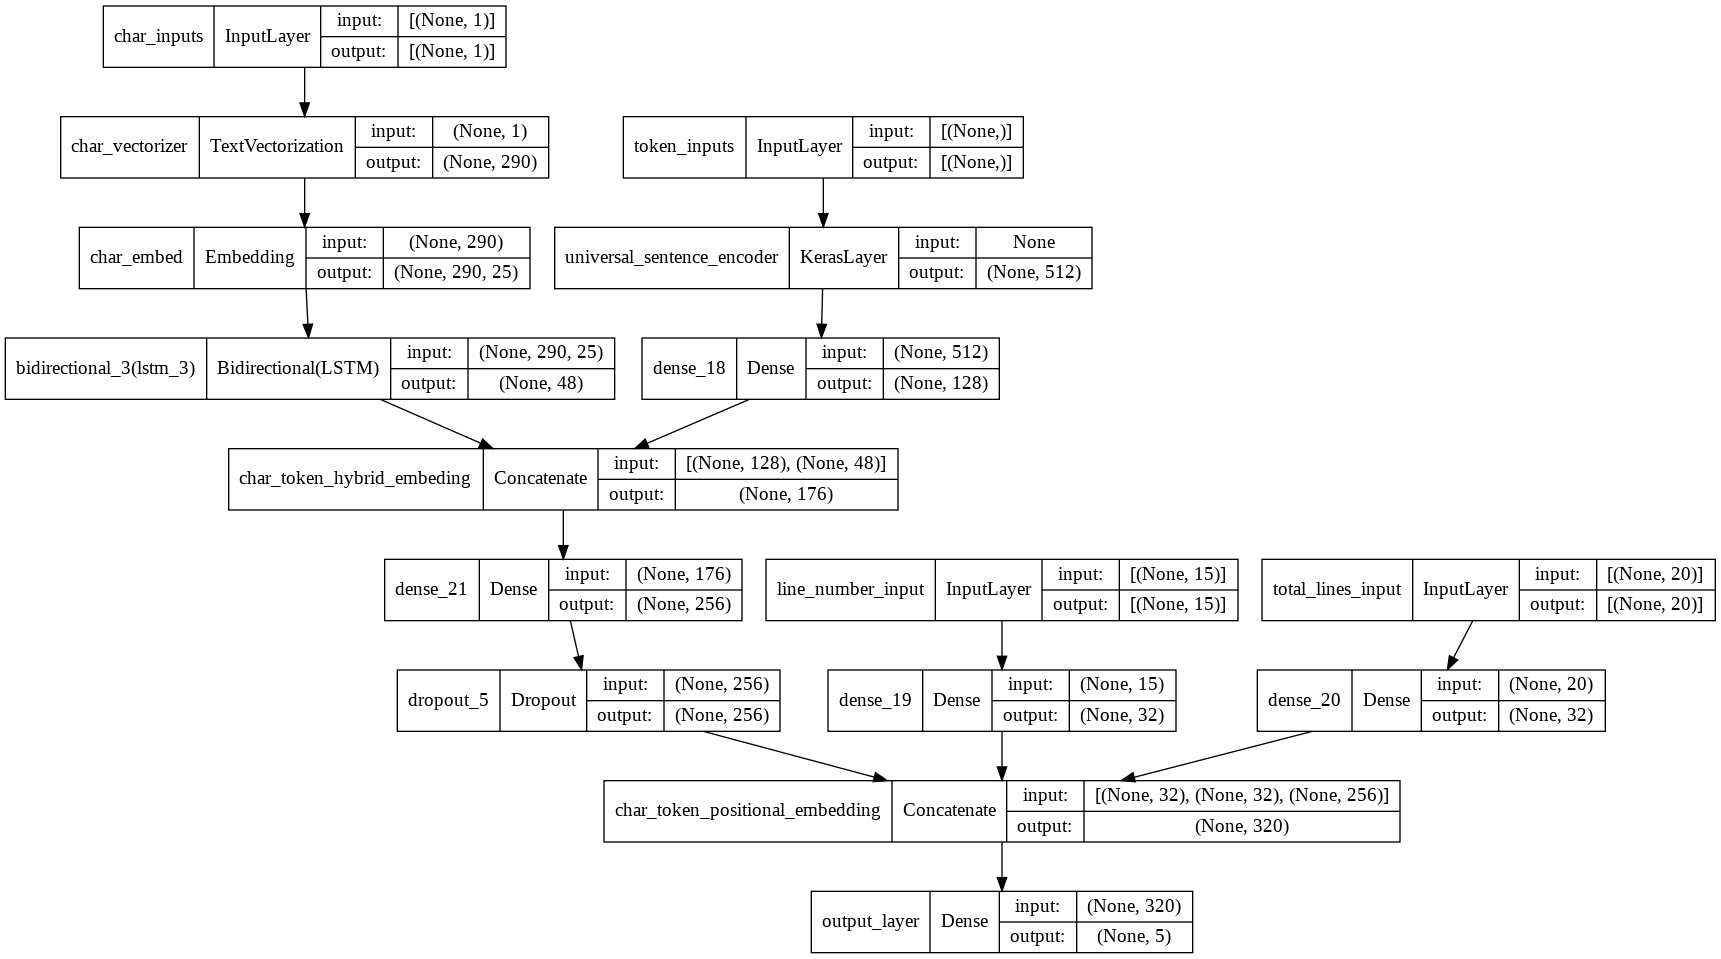

In [ ]:
tf.keras.utils.plot_model(model_5, show_shapes=True)

In [ ]:
# Compile token, char, and positional embeddnings model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps preventing overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Create tribrid embedding datsets using tf.data

In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
# Check input shape
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

## Finding evaluation and making predictions with tribrid model

In [ ]:
# Fit tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 88s 139ms/step - loss: 1.0930 - accuracy: 0.7289 - val_loss: 0.9822 - val_accuracy: 0.8029
Epoch 2/3
562/562 [==============================] - 75s 133ms/step - loss: 0.9665 - accuracy: 0.8150 - val_loss: 0.9495 - val_accuracy: 0.8275
Epoch 3/3
562/562 [==============================] - 71s 126ms/step - loss: 0.9487 - accuracy: 0.8230 - val_loss: 0.9385 - val_accuracy: 0.8308


In [ ]:
# Make predictions with the char token pso model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 54s 53ms/step


array([[0.49231896, 0.09905165, 0.01071729, 0.3835583 , 0.01435382],
       [0.49333417, 0.10364966, 0.06356919, 0.32811597, 0.01133108],
       [0.26778033, 0.11343161, 0.15049739, 0.38698885, 0.08130184],
       ...,
       [0.03000318, 0.11525264, 0.04118042, 0.02504677, 0.788517  ],
       [0.03310768, 0.27486092, 0.09533107, 0.0243833 , 0.572317  ],
       [0.25849497, 0.5393427 , 0.1115566 , 0.04156298, 0.04904277]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of char
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.20865881106845,
 'f1': 0.8311549047866521,
 'precision': 0.8310485784531723,
 'recall': 0.8320865881106845}

## Compare model results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "modle_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.402621,0.780464,0.784026,0.781703
model_2_pretrained_token_embedding,71.471601,0.714675,0.714716,0.711440
model_3_custom_char_embedding,65.255528,0.647859,0.652555,0.643284
model_4_hybrid_char_token_embedding,73.232490,0.734039,0.732325,0.729629
modle_5_pos_char_token_embedding,83.208659,0.831049,0.832087,0.831155


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"] / 100

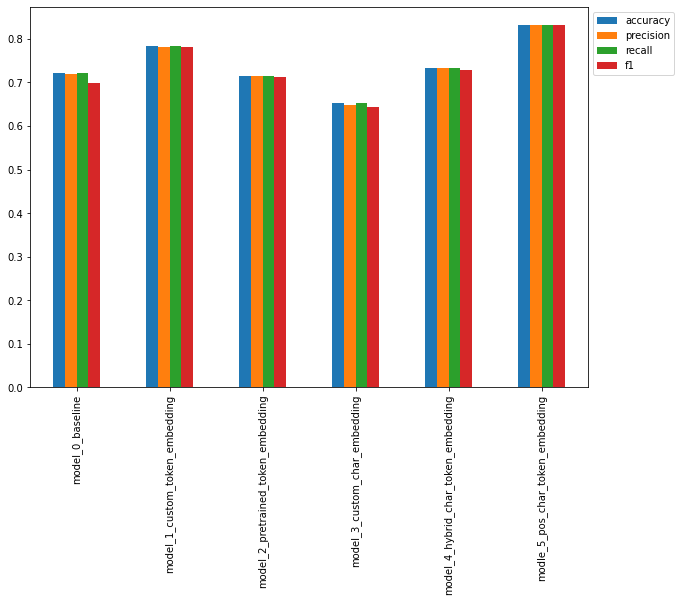

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

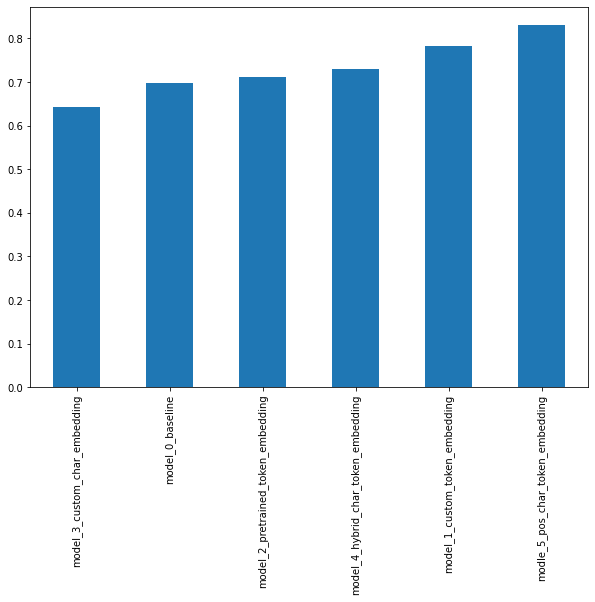

In [ ]:
# Sort models results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));

# Save and load model

In [ ]:
# Save model to SavedModel format(default)
model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
# Load in the best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

ValueError: ignored

In [ ]:
# Make 